In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from torchvision import transforms


from model.EfficientNet import EfficientNet
from trainer.process_data import CatTripletDataset, load_cat_data
from trainer.evaluate import evaluate_model  # NEW: Import evaluation module

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA device: {torch.cuda.get_device_name(0)}')

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA RTX A5500


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
CONFIG = {
    'BATCH_SIZE': 64,
    'EMBEDDING_DIM': 128,
    'NUM_EPOCHS': 50,
    'LEARNING_RATE': 1e-5,
    'TRAIN_SUBSET_SIZE': 131280,     # cats/epoch for train
    'VAL_SUBSET_SIZE': 16000,        # cats/epoch for val
    'TEST_SUBSET_SIZE': 16000,       # cats/epoch for test
    'TRAIN_TRIPLETS_PER_EPOCH': 1000000,
    'VAL_TRIPLETS': 100000,
    'TEST_TRIPLETS': 100000,
    'MARGIN': 1.0,                   # Triplet loss margin
    'PATIENCE': 10,
    'DATASET_PATH': './cat',
}
print("TRAINING CONFIGURATION")
print("-"*60)
for key, value in CONFIG.items():
    print(f"{key:<25} {value}")

Using device: cuda
TRAINING CONFIGURATION
------------------------------------------------------------
BATCH_SIZE                64
EMBEDDING_DIM             128
NUM_EPOCHS                50
LEARNING_RATE             1e-05
TRAIN_SUBSET_SIZE         131280
VAL_SUBSET_SIZE           16000
TEST_SUBSET_SIZE          16000
TRAIN_TRIPLETS_PER_EPOCH  1000000
VAL_TRIPLETS              100000
TEST_TRIPLETS             100000
MARGIN                    1.0
PATIENCE                  10
DATASET_PATH              ./cat


In [12]:
print("\nLoading dataset...")
image_paths, labels = load_cat_data(CONFIG['DATASET_PATH'])

print(f"\nTotal images: {len(image_paths):,}")
print(f"Total unique cats: {len(set(labels)):,}")


Loading dataset...
Loading data from: ./cat
Found 164100 cat folders


Loading cats: 100%|██████████| 164100/164100 [00:20<00:00, 7870.31it/s]



Loaded 643539 images from 164100 unique cats

Total images: 643,539
Total unique cats: 164,100


In [13]:
unique_cats = sorted(list(set(labels)))
print(f'Total unique cats: {len(unique_cats):,}')

# First split: train vs (val+test)
train_cat_ids, temp_cat_ids = train_test_split(
    unique_cats, 
    test_size=0.2, 
    random_state=42
)
# Second split: val vs test (from temp)
val_cat_ids, test_cat_ids = train_test_split(
    temp_cat_ids,
    test_size=0.5,   
    random_state=42
)

train_cat_ids = set(train_cat_ids)
val_cat_ids = set(val_cat_ids)
test_cat_ids = set(test_cat_ids)

print(f'Train cats: {len(train_cat_ids):,}')
print(f'Val cats: {len(val_cat_ids):,}')
print(f'Test cats: {len(test_cat_ids):,}')

# Split images based on set
train_paths, train_labels = [], []
val_paths, val_labels = [], []
test_paths, test_labels = [], []

for img_path, cat_id in zip(image_paths, labels):
    if cat_id in train_cat_ids:
        train_paths.append(img_path)
        train_labels.append(cat_id)
    elif cat_id in val_cat_ids:
        val_paths.append(img_path)
        val_labels.append(cat_id)
    else:
        test_paths.append(img_path)
        test_labels.append(cat_id)

print(f'\nTraining images: {len(train_paths):,}')
print(f'Validation images: {len(val_paths):,}')
print(f'Test images: {len(test_paths):,}')
print(f'Training cats: {len(set(train_labels)):,}')
print(f'Validation cats: {len(set(val_labels)):,}')
print(f'Test cats: {len(set(test_labels)):,}')

Total unique cats: 164,100
Train cats: 131,280
Val cats: 16,410
Test cats: 16,410

Training images: 515,159
Validation images: 64,266
Test images: 64,114
Training cats: 131,280
Validation cats: 16,410
Test cats: 16,410


In [14]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

test_transform = val_transform

In [17]:
train_dataset = CatTripletDataset(
    train_paths, 
    train_labels, 
    transform=train_transform,
    subset_size=CONFIG['TRAIN_SUBSET_SIZE'],
    triplets_per_epoch=CONFIG['TRAIN_TRIPLETS_PER_EPOCH']
)

val_dataset = CatTripletDataset(
    val_paths, 
    val_labels, 
    transform=val_transform,
    subset_size=CONFIG['VAL_SUBSET_SIZE'],
    triplets_per_epoch=CONFIG['VAL_TRIPLETS']
)
test_dataset = CatTripletDataset(
    test_paths,
    test_labels,
    transform=test_transform,
    subset_size=CONFIG["TEST_SUBSET_SIZE"],
    triplets_per_epoch=CONFIG["TEST_TRIPLETS"]
)

# DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['BATCH_SIZE'], 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['BATCH_SIZE'], 
    shuffle=False, 
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f'\nTrain batches: {len(train_loader):,}')
print(f'Val batches: {len(val_loader):,}')
print(f'Test batches: {len(test_loader):,}')

Total cats: 131280
Total images: 515159
Sampling from 131280 cats...


Generating triplets: 100%|██████████| 1000000/1000000 [1:04:04<00:00, 260.12it/s]


Total triplets generated: 1000000
Total cats: 16410
Total images: 64266
Sampling from 16000 cats...


Generating triplets: 100%|██████████| 100000/100000 [00:39<00:00, 2507.91it/s]


Total triplets generated: 100000
Total cats: 16410
Total images: 64114
Sampling from 16000 cats...


Generating triplets: 100%|██████████| 100000/100000 [00:40<00:00, 2467.85it/s]

Total triplets generated: 100000

Train batches: 15,625
Val batches: 1,563
Test batches: 1,563


In [18]:
model = EfficientNet(embedding_dim=CONFIG['EMBEDDING_DIM'])
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("MODEL SUMMARY")
print(f'{"-"*60}')
print(f'Total parameters:     {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Model size:           {total_params * 4 / 1024 / 1024:.2f} MB')
print(f'Device:               {next(model.parameters()).device}')

/data/axnguyen/Env/Anaconda/envs/PetFaceSiamese/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/axnguyen/Env/Anaconda/envs/PetFaceSiamese/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MODEL SUMMARY
------------------------------------------------------------
Total parameters:     4,730,364
Trainable parameters: 4,730,364
Model size:           18.04 MB
Device:               cuda:0


In [19]:
criterion = nn.TripletMarginLoss(margin=CONFIG['MARGIN'], p=2)
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"\nLoss: Triplet Margin Loss (margin={CONFIG['MARGIN']})")
print(f"Optimizer: Adam (lr={CONFIG['LEARNING_RATE']})")
print(f"Scheduler: StepLR (step=10, gamma=0.5)")


Loss: Triplet Margin Loss (margin=1.0)
Optimizer: Adam (lr=1e-05)
Scheduler: StepLR (step=10, gamma=0.5)


In [20]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc="Training")
    for anchor, positive, negative in pbar:
        # Move to device
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        anchor_emb = model(anchor)
        pos_emb = model(positive)
        neg_emb = model(negative)
        
        # Compute loss
        loss = criterion(anchor_emb, pos_emb, neg_emb)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)


@torch.no_grad()
def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    
    pbar = tqdm(loader, desc="Validating")
    for anchor, positive, negative in pbar:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        anchor_emb = model(anchor)
        pos_emb = model(positive)
        neg_emb = model(negative)
        
        loss = criterion(anchor_emb, pos_emb, neg_emb)
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)

In [21]:
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rates': []
}

best_val_loss = float('inf')
patience_counter = 0
print("STARTING TRAINING")
print("-"*60)

for epoch in range(CONFIG['NUM_EPOCHS']):
    print(f'\nEpoch {epoch+1}/{CONFIG["NUM_EPOCHS"]}')
    print('-' * 60)
    
    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    
    # Learning rate
    current_lr = optimizer.param_groups[0]['lr']
    history['learning_rates'].append(current_lr)
    
    print(f'\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}')
    
    # Learning rate scheduler
    scheduler.step()
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'config': CONFIG
        }, 'best_efficientnet_triplet.pth')
        print(f'New best val loss: {best_val_loss:.4f} - Model saved!')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs')
    
    if patience_counter >= CONFIG['PATIENCE']:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break

print('\n' + "="*60)
print('TRAINING COMPLETED!')

STARTING TRAINING
------------------------------------------------------------

Epoch 1/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:20<00:00,  7.78it/s, loss=0.1976]



Train Loss: 0.2060 | Val Loss: 0.1413 | LR: 0.000010
✓ New best val loss: 0.1413 - Model saved!

Epoch 2/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:26<00:00,  7.56it/s, loss=0.1822]



Train Loss: 0.1367 | Val Loss: 0.1253 | LR: 0.000010
✓ New best val loss: 0.1253 - Model saved!

Epoch 3/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:16<00:00,  7.95it/s, loss=0.1838]



Train Loss: 0.1234 | Val Loss: 0.1183 | LR: 0.000010
✓ New best val loss: 0.1183 - Model saved!

Epoch 4/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:17<00:00,  7.92it/s, loss=0.1857]



Train Loss: 0.1159 | Val Loss: 0.1145 | LR: 0.000010
✓ New best val loss: 0.1145 - Model saved!

Epoch 5/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:31<00:00,  7.40it/s, loss=0.1796]



Train Loss: 0.1107 | Val Loss: 0.1116 | LR: 0.000010
✓ New best val loss: 0.1116 - Model saved!

Epoch 6/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:22<00:00,  7.73it/s, loss=0.1730]



Train Loss: 0.1064 | Val Loss: 0.1099 | LR: 0.000010
✓ New best val loss: 0.1099 - Model saved!

Epoch 7/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:16<00:00,  7.95it/s, loss=0.1734]



Train Loss: 0.1029 | Val Loss: 0.1087 | LR: 0.000010
✓ New best val loss: 0.1087 - Model saved!

Epoch 8/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:18<00:00,  7.86it/s, loss=0.1749]



Train Loss: 0.1000 | Val Loss: 0.1074 | LR: 0.000010
✓ New best val loss: 0.1074 - Model saved!

Epoch 9/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:24<00:00,  7.63it/s, loss=0.1766]



Train Loss: 0.0971 | Val Loss: 0.1066 | LR: 0.000010
✓ New best val loss: 0.1066 - Model saved!

Epoch 10/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:15<00:00,  7.98it/s, loss=0.1719]



Train Loss: 0.0949 | Val Loss: 0.1055 | LR: 0.000010
✓ New best val loss: 0.1055 - Model saved!

Epoch 11/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:21<00:00,  7.75it/s, loss=0.1690]



Train Loss: 0.0923 | Val Loss: 0.1049 | LR: 0.000005
✓ New best val loss: 0.1049 - Model saved!

Epoch 12/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:39<00:00,  7.13it/s, loss=0.1820]



Train Loss: 0.0910 | Val Loss: 0.1051 | LR: 0.000005
No improvement for 1 epochs

Epoch 13/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:33<00:00,  7.33it/s, loss=0.1768]



Train Loss: 0.0901 | Val Loss: 0.1045 | LR: 0.000005
✓ New best val loss: 0.1045 - Model saved!

Epoch 14/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:17<00:00,  7.90it/s, loss=0.1738]



Train Loss: 0.0891 | Val Loss: 0.1044 | LR: 0.000005
✓ New best val loss: 0.1044 - Model saved!

Epoch 15/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:30<00:00,  7.43it/s, loss=0.1710]



Train Loss: 0.0882 | Val Loss: 0.1041 | LR: 0.000005
✓ New best val loss: 0.1041 - Model saved!

Epoch 16/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:32<00:00,  7.37it/s, loss=0.1770]



Train Loss: 0.0875 | Val Loss: 0.1040 | LR: 0.000005
✓ New best val loss: 0.1040 - Model saved!

Epoch 17/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:41<00:00,  7.06it/s, loss=0.1750]



Train Loss: 0.0867 | Val Loss: 0.1046 | LR: 0.000005
No improvement for 1 epochs

Epoch 18/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:35<00:00,  7.27it/s, loss=0.1734]



Train Loss: 0.0858 | Val Loss: 0.1040 | LR: 0.000005
✓ New best val loss: 0.1040 - Model saved!

Epoch 19/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:31<00:00,  7.38it/s, loss=0.1688]



Train Loss: 0.0853 | Val Loss: 0.1037 | LR: 0.000005
✓ New best val loss: 0.1037 - Model saved!

Epoch 20/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:30<00:00,  7.44it/s, loss=0.1724]



Train Loss: 0.0845 | Val Loss: 0.1037 | LR: 0.000005
✓ New best val loss: 0.1037 - Model saved!

Epoch 21/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:18<00:00,  7.89it/s, loss=0.1698]



Train Loss: 0.0834 | Val Loss: 0.1037 | LR: 0.000003
✓ New best val loss: 0.1037 - Model saved!

Epoch 22/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:29<00:00,  7.48it/s, loss=0.1745]



Train Loss: 0.0830 | Val Loss: 0.1037 | LR: 0.000003
No improvement for 1 epochs

Epoch 23/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:28<00:00,  7.48it/s, loss=0.1756]



Train Loss: 0.0828 | Val Loss: 0.1034 | LR: 0.000003
✓ New best val loss: 0.1034 - Model saved!

Epoch 24/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:30<00:00,  7.41it/s, loss=0.1740]



Train Loss: 0.0825 | Val Loss: 0.1033 | LR: 0.000003
✓ New best val loss: 0.1033 - Model saved!

Epoch 25/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:36<00:00,  7.21it/s, loss=0.1715]



Train Loss: 0.0822 | Val Loss: 0.1033 | LR: 0.000003
No improvement for 1 epochs

Epoch 26/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:42<00:00,  7.02it/s, loss=0.1710]



Train Loss: 0.0816 | Val Loss: 0.1036 | LR: 0.000003
No improvement for 2 epochs

Epoch 27/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:44<00:00,  6.95it/s, loss=0.1740]



Train Loss: 0.0814 | Val Loss: 0.1037 | LR: 0.000003
No improvement for 3 epochs

Epoch 28/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:37<00:00,  7.18it/s, loss=0.1738]



Train Loss: 0.0809 | Val Loss: 0.1032 | LR: 0.000003
✓ New best val loss: 0.1032 - Model saved!

Epoch 29/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:29<00:00,  7.45it/s, loss=0.1763]



Train Loss: 0.0806 | Val Loss: 0.1034 | LR: 0.000003
No improvement for 1 epochs

Epoch 30/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:34<00:00,  7.28it/s, loss=0.1691]



Train Loss: 0.0803 | Val Loss: 0.1034 | LR: 0.000003
No improvement for 2 epochs

Epoch 31/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:51<00:00,  6.76it/s, loss=0.1771]



Train Loss: 0.0800 | Val Loss: 0.1035 | LR: 0.000001
No improvement for 3 epochs

Epoch 32/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:28<00:00,  7.51it/s, loss=0.1718]



Train Loss: 0.0798 | Val Loss: 0.1033 | LR: 0.000001
No improvement for 4 epochs

Epoch 33/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:24<00:00,  7.63it/s, loss=0.1713]



Train Loss: 0.0797 | Val Loss: 0.1035 | LR: 0.000001
No improvement for 5 epochs

Epoch 34/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:36<00:00,  7.22it/s, loss=0.1743]



Train Loss: 0.0794 | Val Loss: 0.1030 | LR: 0.000001
✓ New best val loss: 0.1030 - Model saved!

Epoch 35/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:38<00:00,  7.14it/s, loss=0.1688]



Train Loss: 0.0793 | Val Loss: 0.1033 | LR: 0.000001
No improvement for 1 epochs

Epoch 36/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [04:39<00:00,  5.58it/s, loss=0.1660]



Train Loss: 0.0792 | Val Loss: 0.1033 | LR: 0.000001
No improvement for 2 epochs

Epoch 37/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [04:52<00:00,  5.35it/s, loss=0.1724]



Train Loss: 0.0790 | Val Loss: 0.1032 | LR: 0.000001
No improvement for 3 epochs

Epoch 38/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s, loss=0.1705]



Train Loss: 0.0788 | Val Loss: 0.1034 | LR: 0.000001
No improvement for 4 epochs

Epoch 39/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [04:44<00:00,  5.49it/s, loss=0.1787]



Train Loss: 0.0787 | Val Loss: 0.1035 | LR: 0.000001
No improvement for 5 epochs

Epoch 40/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [04:49<00:00,  5.40it/s, loss=0.1726]



Train Loss: 0.0785 | Val Loss: 0.1035 | LR: 0.000001
No improvement for 6 epochs

Epoch 41/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:44<00:00,  6.96it/s, loss=0.1772]



Train Loss: 0.0783 | Val Loss: 0.1038 | LR: 0.000001
No improvement for 7 epochs

Epoch 42/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [04:05<00:00,  6.36it/s, loss=0.1682]



Train Loss: 0.0783 | Val Loss: 0.1036 | LR: 0.000001
No improvement for 8 epochs

Epoch 43/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:55<00:00,  6.64it/s, loss=0.1710]



Train Loss: 0.0781 | Val Loss: 0.1034 | LR: 0.000001
No improvement for 9 epochs

Epoch 44/50
------------------------------------------------------------


Validating: 100%|██████████| 1563/1563 [03:51<00:00,  6.74it/s, loss=0.1712]


Train Loss: 0.0781 | Val Loss: 0.1034 | LR: 0.000001
No improvement for 10 epochs

⚠ Early stopping triggered after 44 epochs

✓ TRAINING COMPLETED!


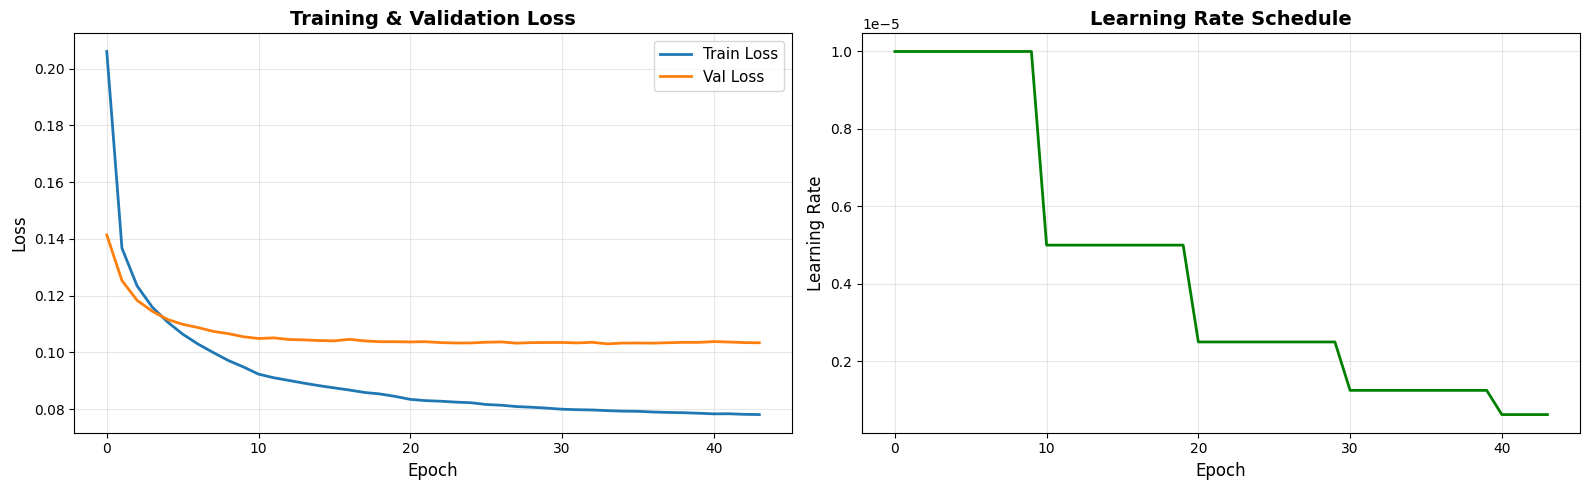

Training history saved as training_history.png
Training history saved as training_history.json


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Learning rate plot
axes[1].plot(history['learning_rates'], color='green', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print('Training history saved as training_history.png')

# Save history JSON
with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=4)
print('Training history saved as training_history.json')

In [23]:
print("\nLoading best model for evaluation...")
checkpoint = torch.load('best_efficientnet_triplet.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded model from epoch {checkpoint['epoch']+1}")
print(f"Best validation loss: {checkpoint['val_loss']:.4f}")


Loading best model for evaluation...
Loaded model from epoch 34
Best validation loss: 0.1030


In [24]:
metrics = evaluate_model(
    model=model, 
    dataset=test_dataset, 
    device=device,
    config=CONFIG,
    num_distance_samples=5000,
    num_embedding_samples=10000
)

print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"F1-Score: {metrics['f1_score']:.4f}")
print(f"ROC-AUC: {metrics['roc_auc']:.4f}")


STARTING EVALUATION

[1/5] Generating embeddings...
Generating embeddings for 10000 samples...


Generating embeddings: 100%|██████████| 10000/10000 [04:42<00:00, 35.39it/s]


✓ Generated embeddings shape: (30000, 128)
✓ Unique cats: 11368

[2/5] Computing distances...
Computing distances for 5000 samples...


Computing distances: 100%|██████████| 5000/5000 [02:14<00:00, 37.09it/s]


✓ Positive pairs: 5000
✓ Negative pairs: 5000

[3/5] Computing metrics...

VERIFICATION METRICS
Accuracy:  0.9509 (95.09%)
Precision: 0.9673
Recall:    0.9334
F1-Score:  0.9500
ROC-AUC:   0.9807
Optimal Threshold: 0.7514

[4/5] Generating visualizations...
✓ Confusion matrix saved as 'confusion_matrix.png'
✓ ROC curve saved as 'roc_curve.png'
✓ Distance distribution saved as 'distance_distribution.png'
Running t-SNE on 1000 samples...
t-SNE completed!
t-SNE plot (top 20) saved
✓ t-SNE plot (all cats) saved

[5/5] Generating summary report...

EVALUATION SUMMARY

Model: EfficientNet-B0 with Triplet Loss
Embedding Dimension: 128

METRICS:
  • Accuracy:   0.9509 
  • Precision:  0.9673
  • Recall:     0.9334
  • F1-Score:   0.9500
  • ROC-AUC:    0.9807

DISTANCE ANALYSIS:
  • Optimal Threshold:       0.7514
  • Same Cat Mean Dist:      0.2750 ± 0.2836
  • Different Cat Mean Dist: 1.3934 ± 0.2297
  • Distance Separation:     1.1184

✓ Evaluation summary saved as 'evaluation_summary.txt'



In [25]:
final_summary = f"""
{'='*70}
SUMMARY
{'='*70}

MODEL ARCHITECTURE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Backbone: EfficientNet-B0
  • Embedding Dimension: {CONFIG['EMBEDDING_DIM']}
  • Total Parameters: {total_params:,}
  • Model Size: {total_params * 4 / 1024 / 1024:.2f} MB

TRAINING CONFIGURATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Loss: Triplet Margin Loss (margin={CONFIG['MARGIN']})
  • Optimizer: Adam (lr={CONFIG['LEARNING_RATE']})
  • Batch Size: {CONFIG['BATCH_SIZE']}
  • Epochs Trained: {len(history['train_loss'])}
  • Early Stopping Patience: {CONFIG['PATIENCE']}

DATASET:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Total Cats: {len(unique_cats):,}
  • Training Cats: {len(train_cat_ids):,}
  • Validation Cats: {len(val_cat_ids):,}
  • Training Images: {len(train_paths):,}
  • Validation Images: {len(val_paths):,}

TRAINING RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Best Train Loss: {min(history['train_loss']):.4f}
  • Best Val Loss: {best_val_loss:.4f}
  • Final Train Loss: {history['train_loss'][-1]:.4f}
  • Final Val Loss: {history['val_loss'][-1]:.4f}

EVALUATION METRICS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)
  • Precision: {metrics['precision']:.4f}
  • Recall: {metrics['recall']:.4f}
  • F1-Score: {metrics['f1_score']:.4f}
  • ROC-AUC: {metrics['roc_auc']:.4f}
  • Optimal Threshold: {metrics['optimal_threshold']:.4f}

DISTANCE ANALYSIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Same Cat Mean: {metrics['pos_dist_mean']:.4f} ± {metrics['pos_dist_std']:.4f}
  • Different Cat Mean: {metrics['neg_dist_mean']:.4f} ± {metrics['neg_dist_std']:.4f}
  • Separation: {metrics['distance_separation']:.4f}
"""

print(final_summary)

# Save final summary
with open('final_summary.txt', 'w') as f:
    f.write(final_summary)

print("\nFinal summary saved as 'final_summary.txt'")


SUMMARY

MODEL ARCHITECTURE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Backbone: EfficientNet-B0
  • Embedding Dimension: 128
  • Total Parameters: 4,730,364
  • Model Size: 18.04 MB

TRAINING CONFIGURATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Loss: Triplet Margin Loss (margin=1.0)
  • Optimizer: Adam (lr=1e-05)
  • Batch Size: 64
  • Epochs Trained: 44
  • Early Stopping Patience: 10

DATASET:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Total Cats: 164,100
  • Training Cats: 131,280
  • Validation Cats: 16,410
  • Training Images: 515,159
  • Validation Images: 64,266

TRAINING RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Best Train Loss: 0.0781
  • Best Val Loss: 0.1030
  • Final Train Loss: 0.0781
  • Final Val Loss: 0.1034

EVALUATION METRICS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Accuracy: 0.9509 (95.09%)
  • Precision: 0.9673
  • Recall: 0.9334
  • F1-Score: 0.9500
  • ROC-AUC: 0.9807
  • Optimal Threshold: 0.7514

DISTANCE ANALYSIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━